# **CASO DE USO 1**
*Creación de modelos de aprendizaje automático para detección de malware*

## 1. Bibliotecas necesarias

In [1]:
# Bibliotecas generales
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import statistics
import sklearn
import time
import os

# Estandarización
from sklearn.preprocessing import StandardScaler

# División del dataset en un conjunto de entrenamiento y en un conjunto de test
from sklearn.model_selection import train_test_split

# Sobremuestreo y submuestreo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Validación cruzada
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Bibliotecas de Algoritmos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Métricas de precisión
from sklearn.metrics import accuracy_score

# Imprimir datos tabulados
from tabulate import tabulate

# Almacenar los modelos
import pickle

## 2. Carga del conjunto de datos

In [2]:
for dirname, _, filenames in os.walk('C:/UOC/jtripos/TFG/CU1/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/UOC/jtripos/TFG/CU1/fullDataset.csv
C:/UOC/jtripos/TFG/CU1/legitimateDataset.csv
C:/UOC/jtripos/TFG/CU1/malwareDataset.csv


In [3]:
malwareDataset = pd.read_csv('C:/UOC/jtripos/TFG/CU1/malwareDataset.csv')
legitimateDataset = pd.read_csv('C:/UOC/jtripos/TFG/CU1/legitimateDataset.csv')

# Fusión de los datasets de malware y de archivos legítimos en un único conjunto de datos llamado fullDataset
fullDataset = pd.concat([legitimateDataset, malwareDataset], ignore_index=True)
fullDataset.to_csv('C:/UOC/jtripos/TFG/CU1/fullDataset.csv')

### 2.1 Exploración del conjunto de datos

In [4]:
fullDataset.shape

(17428, 54)

Observamos que el dataset resultante de la fusión tiene un total de 54 características y 17428 registros.

In [5]:
# Observamos las 54 características
fullDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17428 entries, 0 to 17427
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         17428 non-null  object 
 1   e_magic                      17428 non-null  int64  
 2   e_cblp                       17428 non-null  int64  
 3   e_cp                         17428 non-null  int64  
 4   e_crlc                       17428 non-null  int64  
 5   e_cparhdr                    17428 non-null  int64  
 6   e_minalloc                   17428 non-null  int64  
 7   e_maxalloc                   17428 non-null  int64  
 8   e_ss                         17428 non-null  int64  
 9   e_sp                         17428 non-null  int64  
 10  e_csum                       17428 non-null  int64  
 11  e_ip                         17428 non-null  int64  
 12  e_cs                         17428 non-null  int64  
 13  e_lfarlc        

## 3. Creación de funciones y explicación de conceptos que se utilizarán

### 3.1 Desviación estándar

La desviación estándar es una medida de dispersión o variabilidad en un conjunto de datos, que indica cuánto se desvían los valores individuales de la media del conjunto de datos. Una desviación estándar baja indica que los datos están muy cerca de la media, mientras que una desviación estándar alta indica que los datos están más dispersos alrededor de la media.

La desviación estándar ($\sigma$) se calcula tomando la raíz cuadrada de la varianza ($\sigma^{2}$), quien, a su vez, es la media de las diferencias al cuadrado entre cada valor del dataset y la media del conjunto de datos.


La fórmula para la desviación estándar es la siguiente:

$\sigma=\sqrt{\sigma^{2}}$

La fórmula de la varianza es la siguiente:

$\sigma^{2}={\frac{{\displaystyle \sum_{i=1}^{N}\left(x_{i}-\mu\right)^{2}}}{N}}$

Todo esto es importante porque si tenemos desviación estándar ***cero*** en un conjunto de datos significa que todos los valores en ese conjunto son idénticos.

Llevado esto a nuestro caso de uso, si una determinada característica del dataset tiene desviación estándar 0, significa que ese campo no será muy relevante a la hora de realizar una correcta clasificación de nuestros archivos.

Con la siguiente función se podrá obtener aquellas características cuya desviación estándar es 0; que luego utilizaremos para poder relizar determinadas operaciones.

In [6]:
# Función que devuelve aquellas características del dataset cuya desviación estándar es 0.

def getZeroStdFeatures():
    global malwareDataset
    global legitimateDataset

    legitimate = legitimateDataset
    malware = malwareDataset
    
    zeroFeat = ['Name', 'Malware']
    staticsFeats = ['Name', 'Malware']
    
    leg = legitimate.drop(staticsFeats, axis=1)
    mal =malware.drop(staticsFeats, axis=1)

    for feature in leg.columns:
        if leg[feature].std() == 0:
            zeroFeat.append(feature)

    for feature in mal.columns:
        if mal[feature].std() == 0:
            if feature not in zeroFeat:
                zeroFeat.append(feature)

    return zeroFeat

Función para obtener todas las características del dataset:

In [7]:
def getAllFeatures():
    global fullDataset

    fullData = fullDataset
    
    allFeats = []
    staticsFeats = ['Name', 'Malware']
    
    full = fullData.drop(staticsFeats, axis=1)

    for feature in full.columns:
        allFeats.append(feature)

    return allFeats

### 3.2 Estandarización
La estandarización más habitual consiste en convertir cada valor en su puntuación típica, es decir, restarle el valor medio y dividirlo por su desviación típica.

Formalmente, dada una muestra $x_1, x_2, ..., x_n$, para realizar su estandarización, calculamos:

$z_i = \frac{x_i - \mu}{\sigma}$

Para realizar este tipo de estandarización, emplearemos la clase sklearn.preprocessing.***StandardScaler*** de la librería scikit-learn.

In [8]:
def performStandardization(X_train):
    # Proceso de estandarización de las características donde se centran alrededor de cero (media = 0) y se escalan para tener una varianza unitaria (desviación estándar = 1).
    # Luego, este objeto final (result) se ajustará a los datos de entrenamiento X_train para calcular la media y la desviación estándar de cada característica.
    result = StandardScaler().fit(X_train)
    return result

### 3.3 División del dataset en un conjunto de entrenamiento y en un conjunto de test

Los algoritmos de Machine Learning aprenden de los datos con los que los entrenamos. A partir de ellos, intentan encontrar o inferir el patrón que les permita predecir el resultado para un nuevo caso. Pero, para poder calibrar si un modelo funciona, necesitaremos probarlo con un conjunto de datos diferente. Por ello, en todo proceso de aprendizaje automático, los datos de trabajo se dividen en dos partes: datos de entrenamiento y datos de prueba o test.

Los datos de entrenamiento o *training data* son los datos que usamos para entrenar un modelo y los datos de prueba, validación o *testing data* son los datos que nos reservamos para comprobar si el modelo que hemos generado a partir de los datos de entrenamiento funciona.

Normalmente el conjunto de datos se suele repartir en un 80% de datos de entrenamiento y un 20% de datos de test, pero se puede variar la proporción según el caso. Lo importante es ser conscientes de que hay que evitar el sobreajuste u "overfitting" y el subajuste o "underfitting", pero eso son aspectos de los que hablaremos más adelante.

<img src="https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/1_train-test-split_0.jpg" alt="TrainTestSplit" width="900">

Fuente: https://builtin.com

In [9]:
# Función que recibe todo el conjunto "X" de características y todo el conjunto "y" de muestras clasificadas,
# del dataset completo de muestras de malware y archivos legítimos, y lo divide en dos conjuntos: un conjunto
# de entrenamiento (80%) y un conjunto de validación (20%).

def splitInTrainAndTest(X, y):
    # Dividimos del conjunto de datos en dos partes: un conjunto de entrenamiento y un conjunto de prueba.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Aplicamos la técnica de estandarización al conjunto de entrenamiento
    standarization = performStandardization(X_train)

    # Partiendo de los datos de X_train, los transformamos según las estadísticas de la transformación de estandarización calculada en la línea anterior.
    # Esta transformación ajustará las características para que tengan una media de 0 y una desviación estándar de 1.
    X_train = standarization.transform(X_train)
    X_test = standarization.transform(X_test)

    return X_train, X_test, y_train, y_test

### 3.4 Balanceo del conjunto de datos
***Overfitting vs underfitting***

Los conjuntos de datos desequilibrados son aquellos en los que una clase tiene significativamente menos instancias que las otras, como es el caso de nuestras muestras de malware vs las legítimas. Como se puede observar en los siguientes gráficos, la cantidad de muestras de malware es muy superior a las muestras de archivos legítimos.

[Text(0, 0, 'Legitimate'), Text(1, 0, 'Malware')]

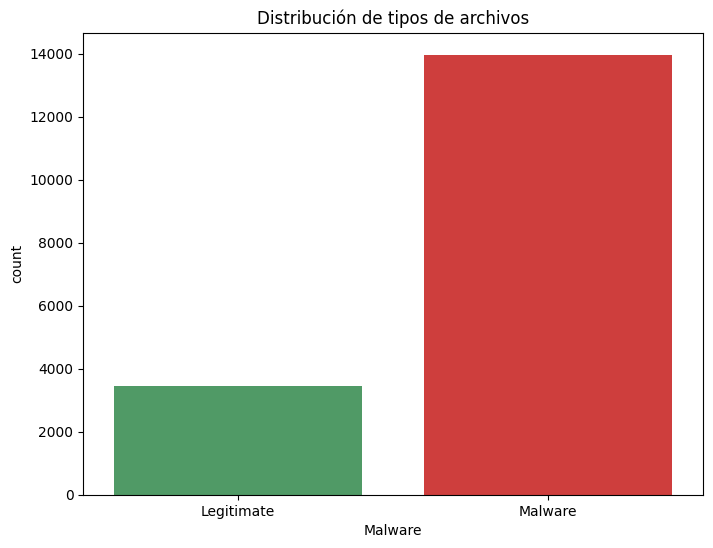

In [10]:
plt.figure(figsize=(8, 6))
plt.title('Distribución de tipos de archivos')
colors = {0: '#44A661', 1: '#E62625'}
ax = sns.countplot(data=fullDataset, x='Malware', hue='Malware', palette=colors, legend=False)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Legitimate', 'Malware'])

Text(0.5, 1.0, 'Distribución de tipos de archivos')

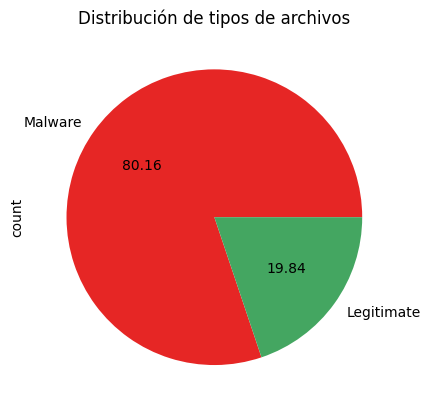

In [11]:
labels = ['Malware', 'Legitimate']
colors = ['#E62625', '#44A661']
fullDataset['Malware'].value_counts().plot.pie(labels = labels, colors=colors, autopct='%.2f')
plt.title('Distribución de tipos de archivos')

Los algoritmos de clasificación pueden funcionar mal cuando se entrenan en conjuntos de datos desequilibrados. El sobremuestreo (oversampling) y el submuestreo (undersampling) pueden resultar útiles a la hora de superar el desequilibrio de clases y, por tanto, mejorar el rendimiento del modelo.

El sobremuestreo aumenta la cantidad de datos que pertenecen a la clase minoritaria al duplicar los existentes o generar otros nuevos mediante la creación de datos sintéticos, mientras que el submuestreo reduce el número de muestras de la clase mayoritaria para adaptar la muestra a la cantidad de datos minoritaria.

Al decidir entre estos dos enfoques para equilibrar un conjunto de datos desequilibrado, se deben considerar sus ventajas y limitaciones.

El ***submuestreo*** o undersampling puede ser eficaz para reducir el almacenamiento de datos y el tiempo de ejecución del código, ya que la cantidad de datos será mucho menor, pero también puede provocar una pérdida de información, lo que daría lugar a modelos sesgados. Una de las técnicas más utilizadas es ***Near Miss***, que disminuye aleatoriamente el número de valores de la clase mayoritaria, y es la que que utilizaremos en este notebook. Near Miss utiliza la menor distancia promedio de los K-vecinos más cercanos, es decir, selecciona los valores en base al método KNN (K-nearest neighbors) para reducir la pérdida de información.

Por otro lado, el ***sobremuestreo*** o oversampling puede ser eficaz cuando los conjuntos de datos son pequeños y hay muestras disponibles limitadas de la clase minoritaria. Pero también puede provocar un sobreajuste debido a la duplicación de datos o la creación de datos sintéticos que no son representativos de los datos reales. Para evitar tener demasiados datos idénticos, utilizaremos la técnica ***SMOTE***, que consiste en sintetizar nueva información a partir de información existente. Estos datos "sintéticos" están relativamente cerca de los datos reales, pero no son idénticos.

En este caso de uso se practicará con ambos enfoques de cara a encontrar el modelo que realice la predicción más exacta.

In [12]:
# Función que recibe todo el conjunto "X" de características y todo el conjunto "y" de muestras clasificadas, y
# realiza un balance de los datos dependiendo de si el remuestreo (resample) es de oversampling o de undersampling.
def balanceDataset(X, y, resample):
    
    if (resample == "o"):
        # Aplicamos técnica de oversampling
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)
    
    elif (resample == "u"):
        # Aplicamos técnica de undersampling
        nearmiss = NearMiss(version=1)
        X, y = nearmiss.fit_resample(X, y)
    
    return X, y

### 3.5 Validación cruzada (cross-validation)

La validación cruzada o *cross-validation* es una técnica para evaluar el rendimiento de un modelo de aprendizaje automático y estimar su capacidad de generalización con nuevos datos desconocidos. En lugar de dividir el conjunto de datos en únicamente dos subconjuntos (entrenamiento y test), como hemos visto en el apartado 3.3, la validación cruzada divide el conjunto de datos en múltiples subconjuntos folds.

En otras palabras, la validación cruzada es una técnica utilizada para garantizar que los resultados arrojados por un modelo de aprendizaje, son independientes de la partición entre los datos de entrenamiento y de test, explicado en el apartado 3.3. Esta técnica consiste en repetir y calcular la media aritmética obtenida de las medidas de evaluación sobre diferentes particiones o subconjuntos.

En el apartado 3.3 hemos visto la teoría sobre cómo particionar nuestro conjunto de datos en un subconjunto de entrenamiento y en un subconjunto de test, pero, con esta información, no sabemos a ciencia cierta si al realizar esta división, las muestras de archivos legítimos y malware han quedado proporcionalmente repartidas. Es decir, puede darse el caso de que el conjunto de entrenamiento esté formado exclusivamente por muestras de malware, ya que, además, esta posibilidad aumenta si nuestro dataset se encuentra desbalanceado que, como ya hemos visto en el apartado anterior, sí se encuentra desbalanceado por contener más muestras de malware que de archivos legítimos.

Con el objetivo de superar esta situación, en este caso de uso se empleará el método K-fold para realizar la validación cruzada de nuestro dataset. Al utilizar múltiples subconjuntos de datos para entrenamiento y test, se reduce la posibilidad de que el rendimiento del modelo esté sesgado por una sola partición de los datos. Esto permite una evaluación más confiable de la capacidad de generalización del modelo.

**Veamos cómo funciona...**

En la validación cruzada de K iteraciones o **K-fold cross-validation** los datos de muestra (en nuestro caso, los datos del dataset llamado ***fullDataset.csv***) se dividen en K subconjuntos. Uno de los subconjuntos se utiliza como datos de test y el resto (K-1) como datos de entrenamiento. El proceso de validación cruzada es repetido durante k iteraciones, con cada uno de los posibles subconjuntos de datos de prueba. Finalmente, se realiza la media aritmética de los resultados de cada iteración para obtener un único resultado.


<img src="https://upload.wikimedia.org/wikipedia/commons/1/18/Esquema_castell%C3%A0.jpg" alt="Texto alternativo" width="600">

*Esquema k-fold cross validation, con k=4 y un solo clasificador*

Fuente: https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada



La elección del número de iteraciones (*K*) depende de la medida del conjunto de datos.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Validación cruzada" width="600">


*Validación cruzada de K iteraciones con K=5*

Fuente: https://scikit-learn.org/stable/modules/cross_validation.html

En este caso de uso, emplearemos la técnica de validación cruzada con **7 iteraciones**.

Para ello, emplearemos la función ***cross_val_score*** de la biblioteca **scikit-learn**, concretamente del módulo *sklearn.model_selection*. Este módulo nos ayudará a realizar validación cruzada y evaluar el rendimiento del modelo. La función *cross_val_score* permite evaluar un algoritmo de aprendizaje automático determinado, utilizando para ello un esquema de validación cruzada específico, y devolver los puntajes de dicha evaluación.

## 4. Selección de características

Comprobamos la desviación estándar de cada uno de los campos de ambos datasets

In [13]:
print("Dataset de archivos legítimos")
display(legitimateDataset.describe())

Dataset de archivos legítimos


,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,e_csum,...,SizeOfImage,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,Malware
count,3457.0,3457.000000,3457.000000,3457.0,3457.000000,3457.0,3457.000000,3457.0,3457.000000,3457.0,...,3.457000e+03,3457.000000,3457.000000,3.457000e+03,3.457000e+03,3.457000e+03,3457.000000,3457.0,3457.0,3457.0
mean,23117.0,142.465722,2.955453,0.0,3.962974,0.0,64378.611513,0.0,180.753254,0.0,...,6.638300e+05,2.426381,23044.165461,4.157008e+05,6.096014e+03,1.031032e+06,4072.303153,0.0,16.0,0.0
std,0.0,13.945560,0.338988,0.0,0.383115,0.0,8629.497463,0.0,24.228695,0.0,...,5.006128e+06,1.011724,14305.019615,4.764581e+05,2.703436e+04,1.478546e+05,461.559435,0.0,0.0,0.0
min,23117.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,1.228800e+04,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,16.0,0.0
25%,23117.0,144.000000,3.000000,0.0,4.000000,0.0,65535.000000,0.0,184.000000,0.0,...,8.192000e+04,2.000000,16704.000000,2.621440e+05,4.096000e+03,1.048576e+06,4096.000000,0.0,16.0,0.0
50%,23117.0,144.000000,3.000000,0.0,4.000000,0.0,65535.000000,0.0,184.000000,0.0,...,1.884160e+05,3.000000,16736.000000,2.621440e+05,4.096000e+03,1.048576e+06,4096.000000,0.0,16.0,0.0
75%,23117.0,144.000000,3.000000,0.0,4.000000,0.0,65535.000000,0.0,184.000000,0.0,...,5.120000e+05,3.000000,17728.000000,2.621440e+05,4.096000e+03,1.048576e+06,4096.000000,0.0,16.0,0.0
max,23117.0,144.000000,3.000000,0.0,4.000000,0.0,65535.000000,0.0,184.000000,0.0,...,2.706104e+08,16.000000,53600.000000,1.677722e+07,1.048576e+06,4.194304e+06,8192.000000,0.0,16.0,0.0


In [14]:
print("Dataset de malware")
display(malwareDataset.describe())

Dataset de malware


,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,e_csum,...,SizeOfImage,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,Malware
count,13971.0,13971.000000,13971.000000,13971.000000,13971.000000,13971.000000,13971.000000,13971.000000,13971.000000,13971.000000,...,1.397100e+04,13971.000000,13971.000000,1.397100e+04,1.397100e+04,1.397100e+04,1.397100e+04,1.397100e+04,1.397100e+04,13971.0
mean,23117.0,912.363968,762.806957,809.569752,635.051678,798.351299,59567.080596,604.588576,1489.536325,769.981462,...,5.830319e+05,2.063990,5682.918832,1.458220e+06,1.074642e+04,1.055453e+06,4.203597e+03,8.423847e+04,7.001848e+04,1.0
std,0.0,5242.399208,5073.346685,5276.422859,4516.155640,5356.133154,17240.229743,5208.390152,6481.584380,5532.380654,...,2.495443e+06,0.253648,12511.080547,8.101932e+06,4.260590e+05,1.606163e+05,9.006705e+03,9.955553e+06,8.274225e+06,0.0
min,23117.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.120000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.000000,0.000000,...,5.324800e+04,2.000000,0.000000,1.048576e+06,4.096000e+03,1.048576e+06,4.096000e+03,0.000000e+00,1.600000e+01,1.0
50%,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.000000,0.000000,...,1.351680e+05,2.000000,0.000000,1.048576e+06,4.096000e+03,1.048576e+06,4.096000e+03,0.000000e+00,1.600000e+01,1.0
75%,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.000000,0.000000,...,3.194880e+05,2.000000,0.000000,1.048576e+06,4.096000e+03,1.048576e+06,4.096000e+03,0.000000e+00,1.600000e+01,1.0
max,23117.0,62868.000000,64140.000000,63994.000000,65490.000000,65447.000000,65535.000000,65520.000000,65534.000000,65324.000000,...,1.387889e+08,3.000000,49632.000000,4.708106e+08,5.000000e+07,4.194304e+06,1.052672e+06,1.176736e+09,9.780050e+08,1.0


Se observa como existen varias características que tienen desviación estándar 0. El siguiente paso es construir un dataset sin estos campos, ya que, no serán relevantes para la predicción del modelo.

**Construcción del conjunto de datos sin aquellas características que tengan desviación estándar 0**

In [15]:
# Asignamos a la variable X todos aquellos campos del dataset fusionado excepto el campo "Malware" que es el campo clasificatorio
X = fullDataset.iloc[:, :-1]

# Asignamos a la variable y el campo objetivo (Malware)
y = fullDataset.loc[:, ['Malware']]

# Obtenemos aquellos campos que tengan desviación estándar 0
zeroStdFeatures = getZeroStdFeatures()

#Observamos cuáles son aquellos campos que tienen desviación estándar 0
zeroStdFeatures


['Name',
 'Malware',
 'e_magic',
 'e_crlc',
 'e_minalloc',
 'e_ss',
 'e_csum',
 'e_ip',
 'e_cs',
 'e_lfarlc',
 'e_ovno',
 'PointerToSymbolTable',
 'NumberOfSymbols',
 'LoaderFlags',
 'NumberOfRvaAndSizes']

In [16]:
# Borramos de la variable X aquellos campos que tienen desviación estándar 0
X = fullDataset.drop(zeroStdFeatures, axis=1)

### 4.1 Análisis de las características del conjunto de datos

Uno de los componentes fundamentales de cualquier análisis de datos es explorar las potenciales relaciones que puedan existir entre las variables que están siendo analizadas. Para esto, se utiliza una medida estadística llamada correlación, que nos indica tanto la magnitud como la dirección de la relación que podría haber entre dos variables.

Comenzaremos por explorar la relación existente entre cada variable independiente y la variable dependiente (nuestro objetivo, "Malware") y, a continuación, graficaremos y analizaremos la matriz de correlaciones.

<Figure size 1200x14000 with 0 Axes>

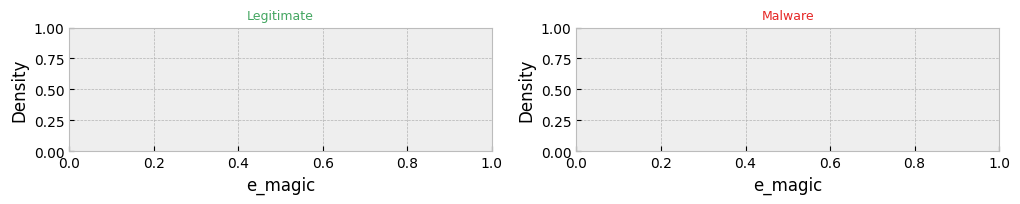

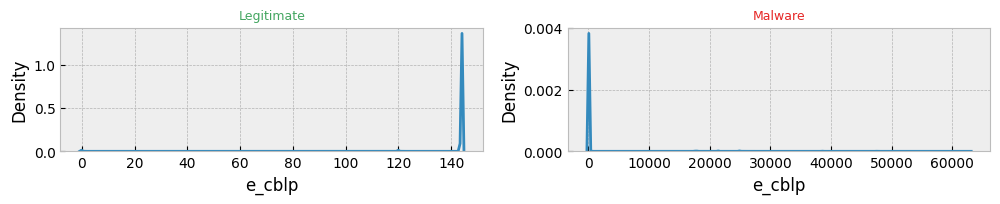

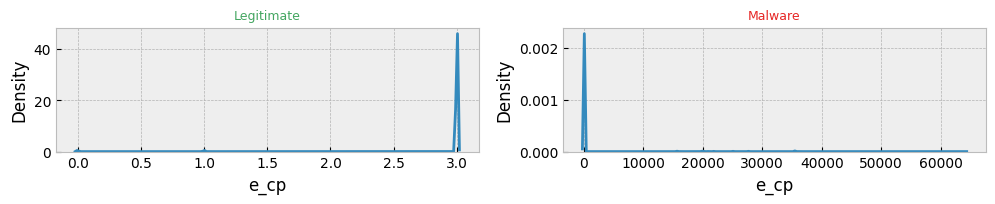

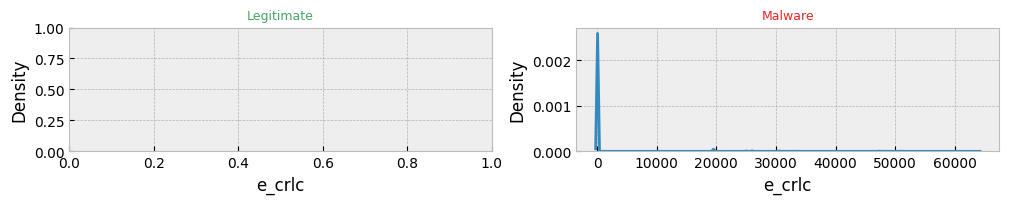

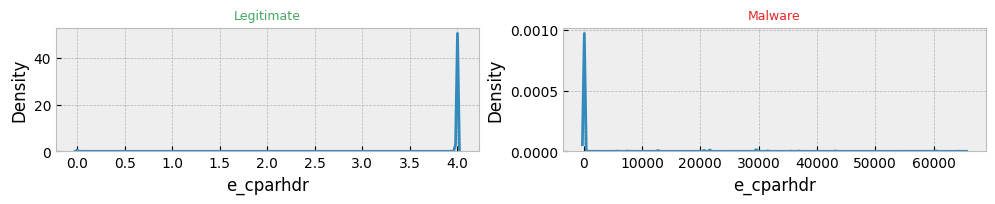

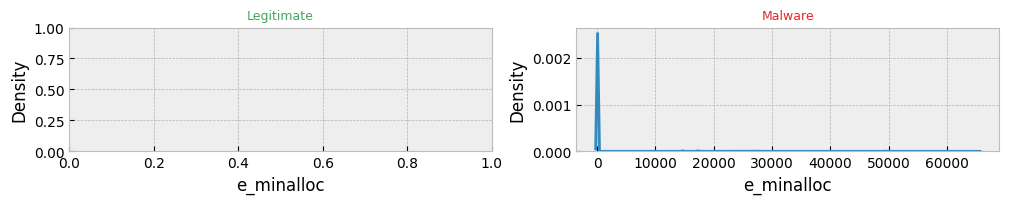

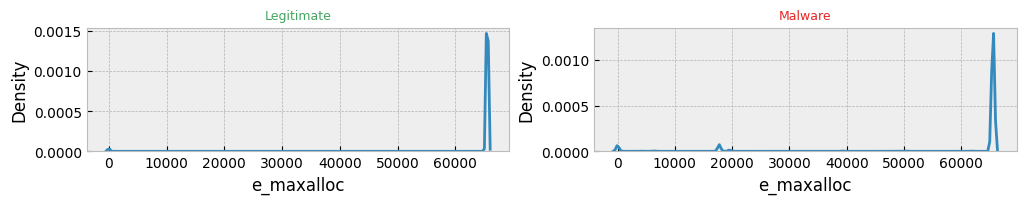

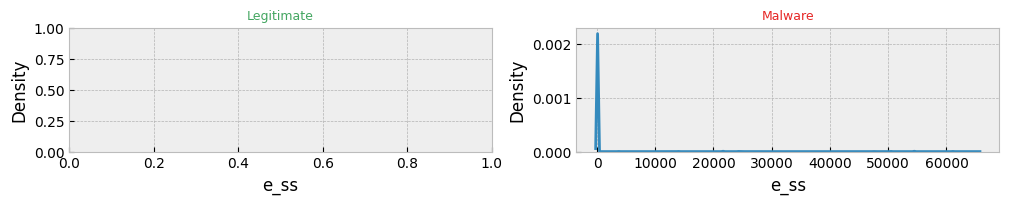

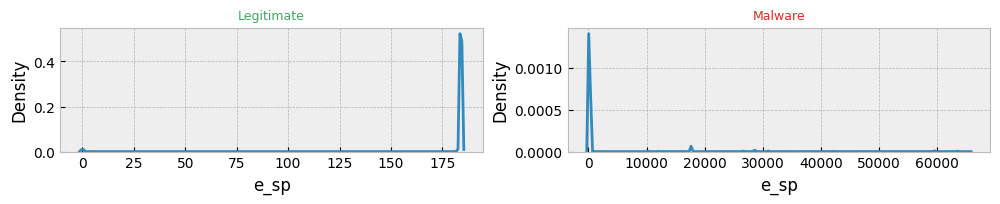

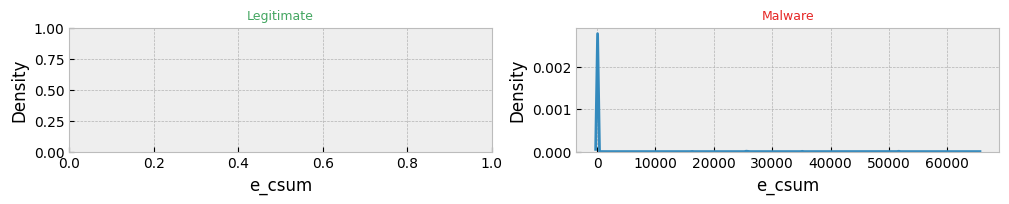

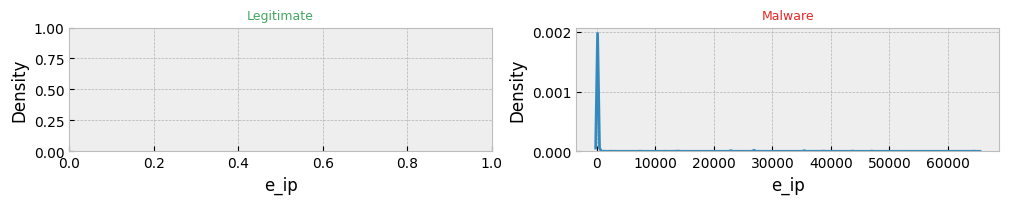

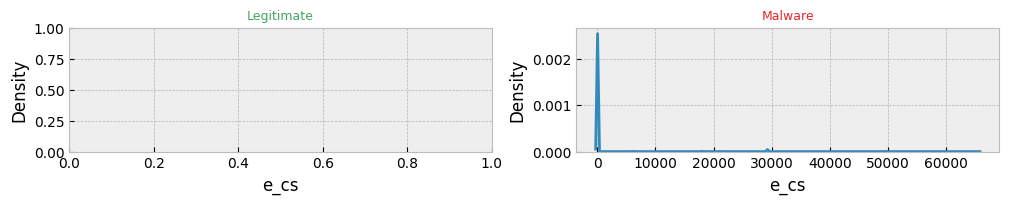

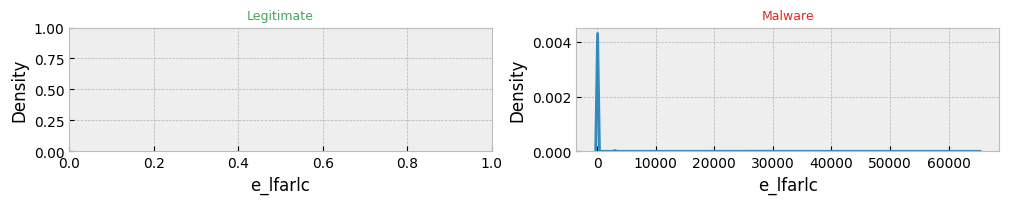

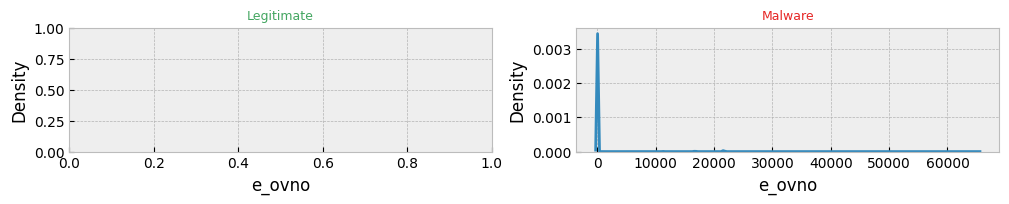

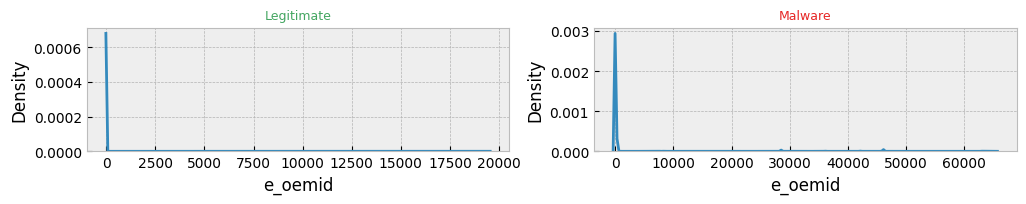

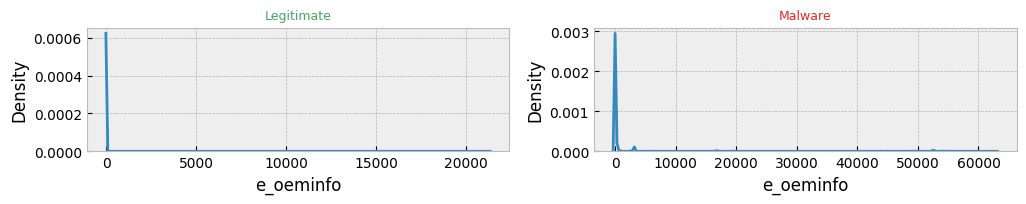

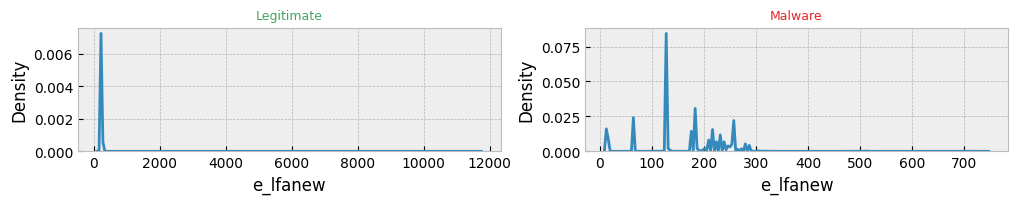

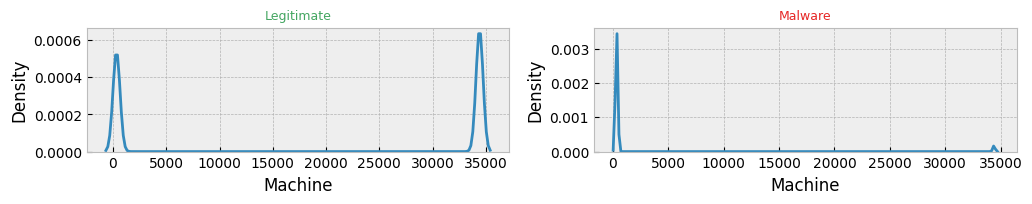

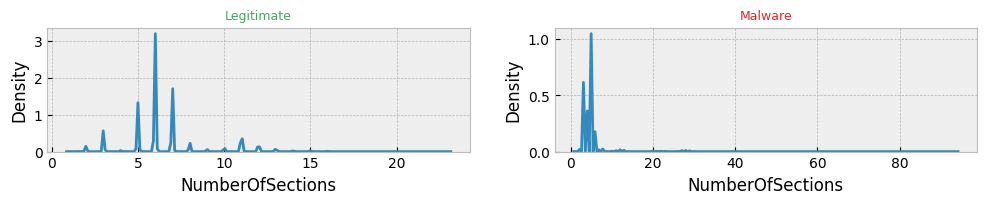

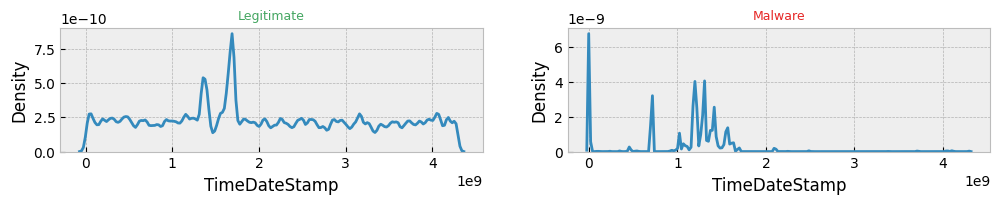

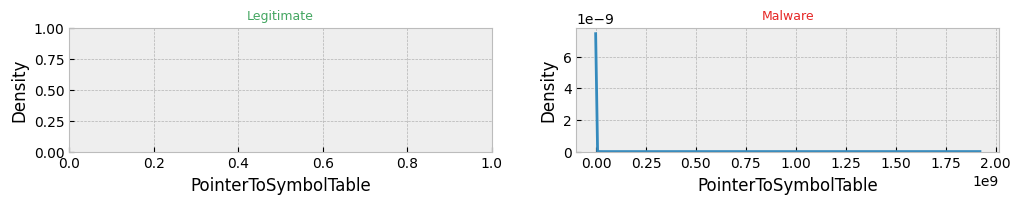

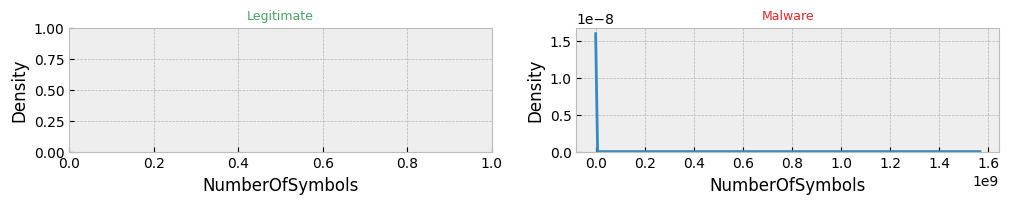

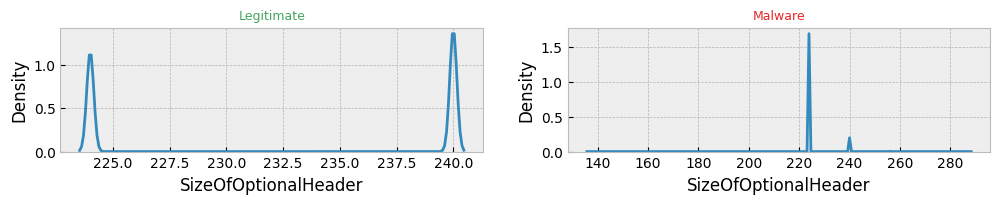

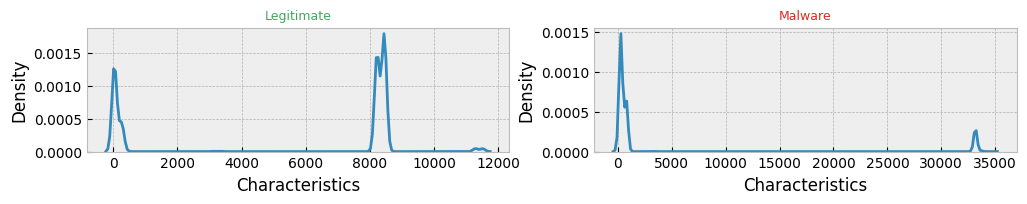

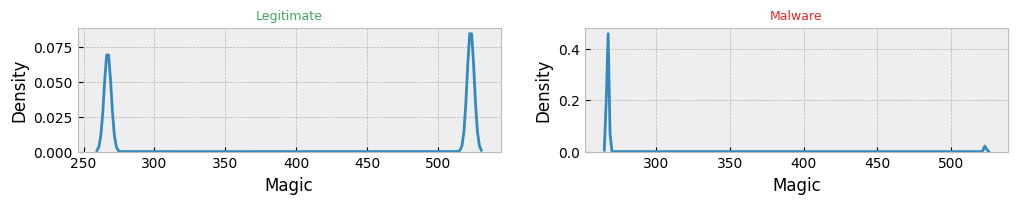

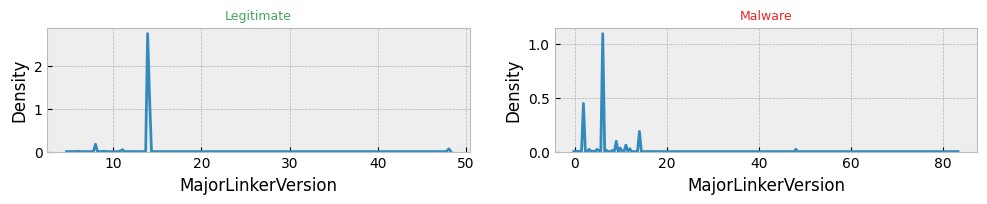

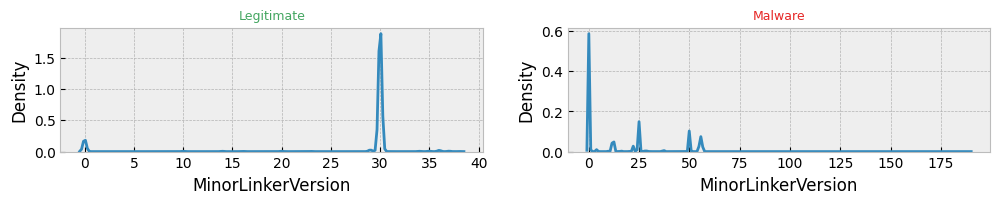

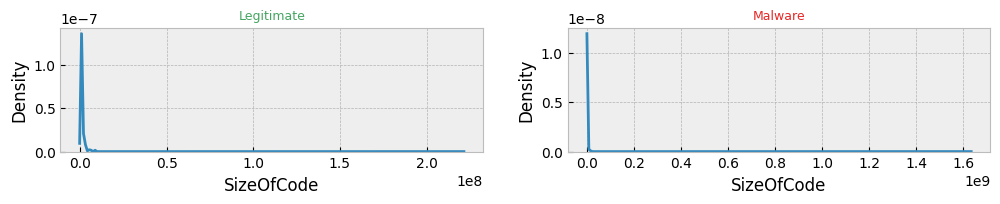

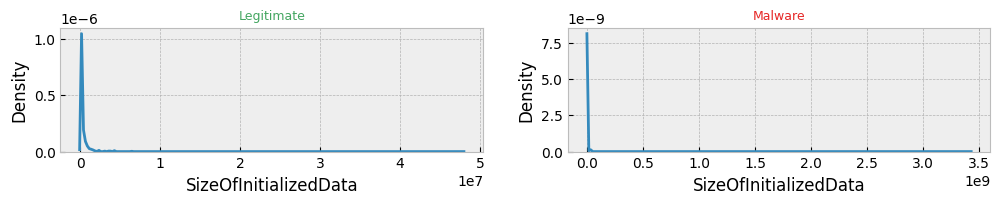

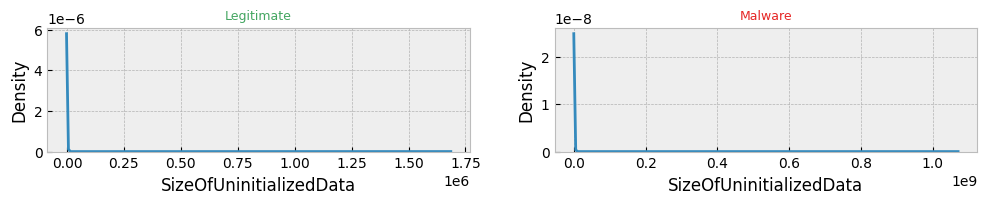

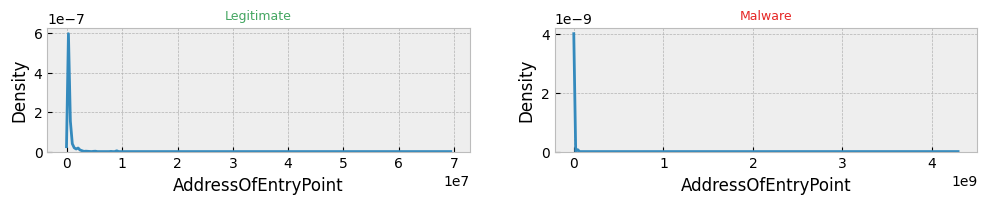

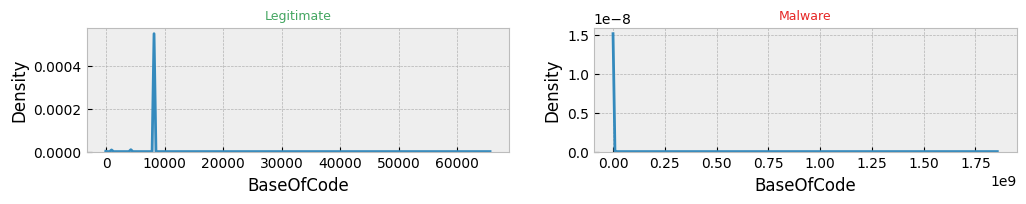

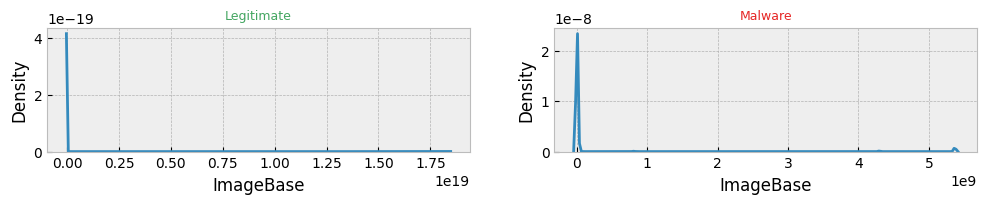

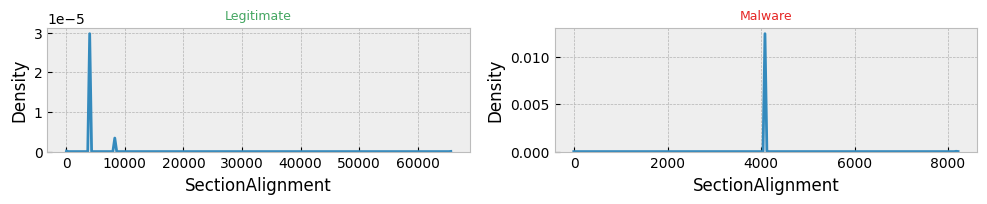

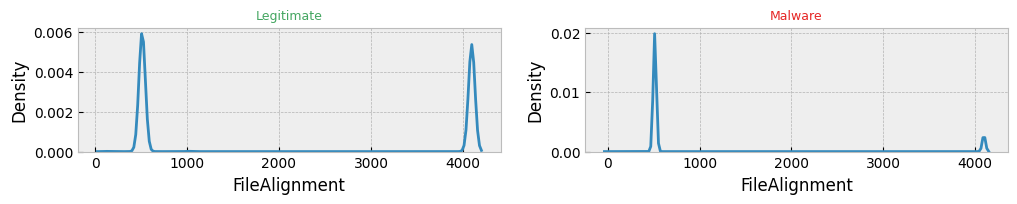

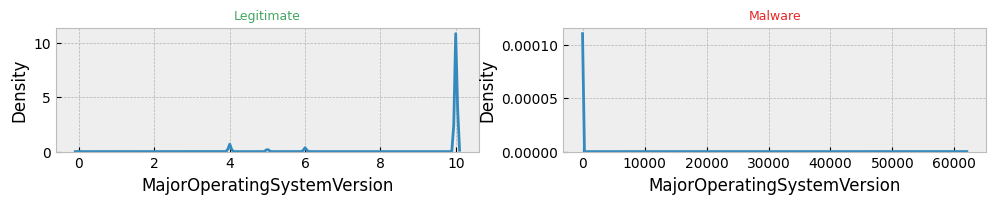

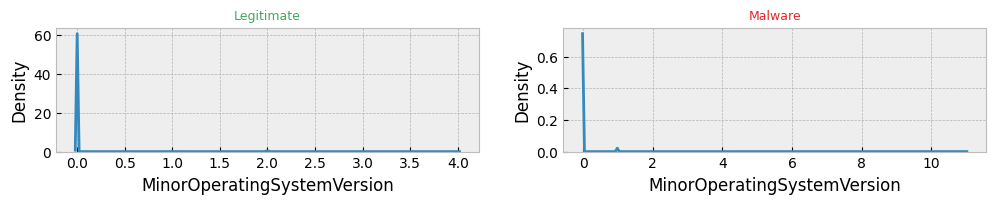

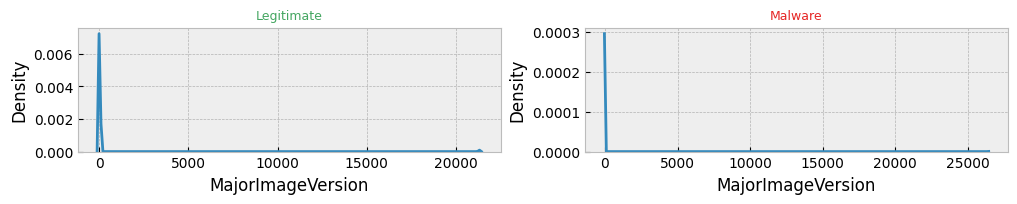

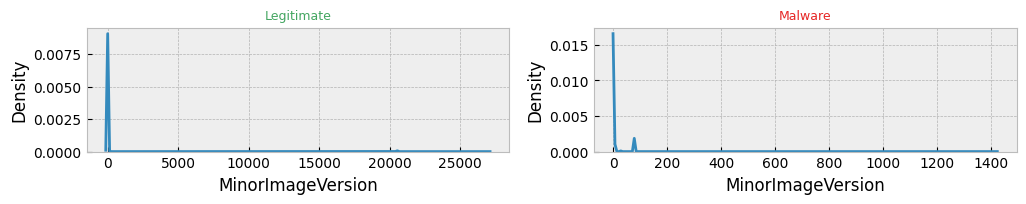

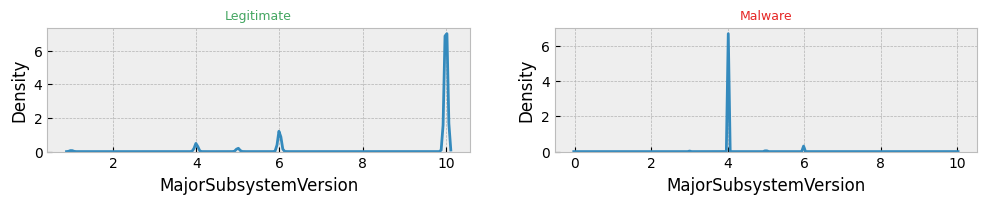

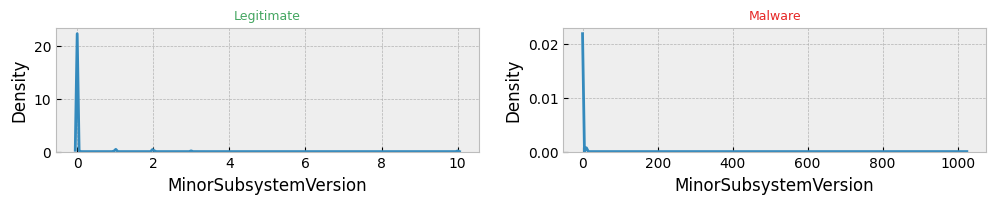

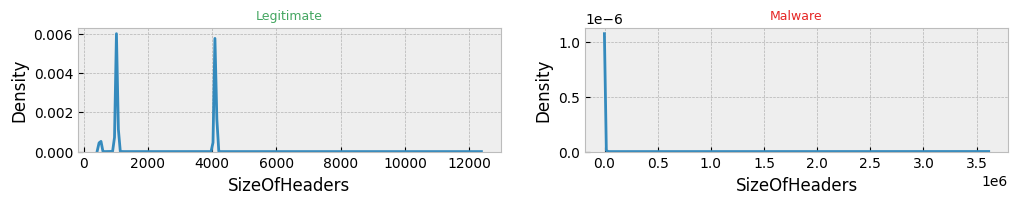

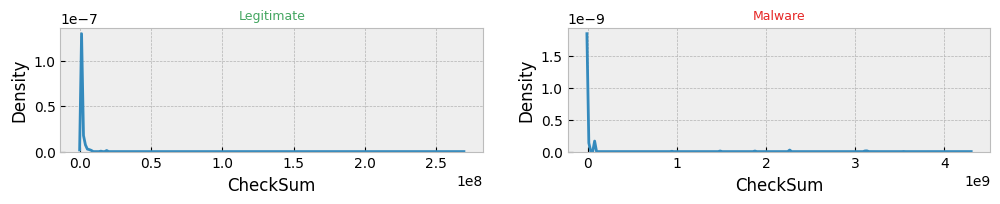

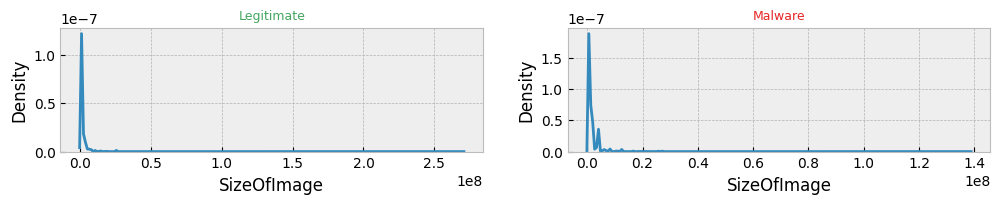

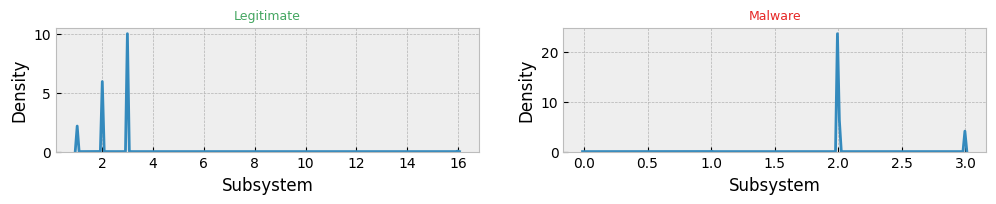

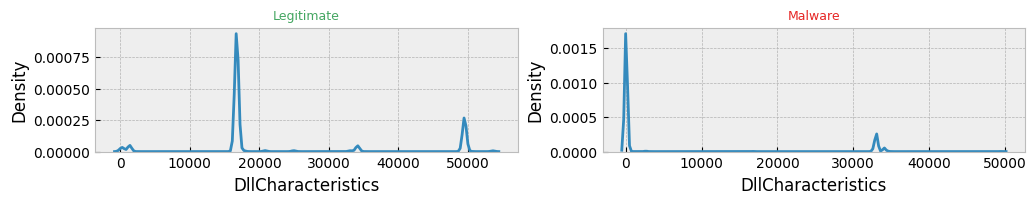

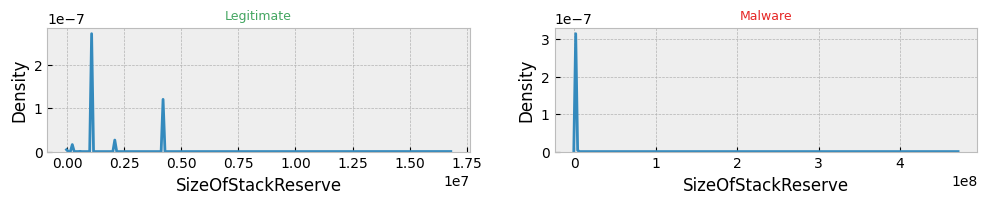

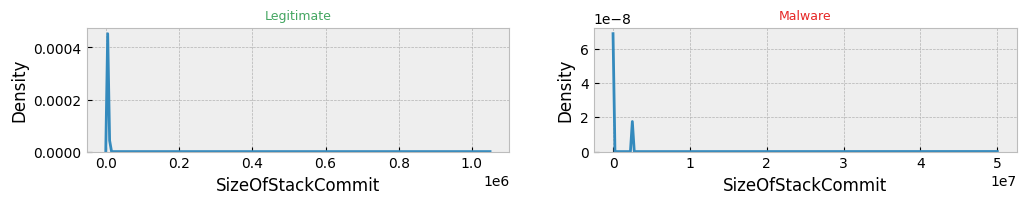

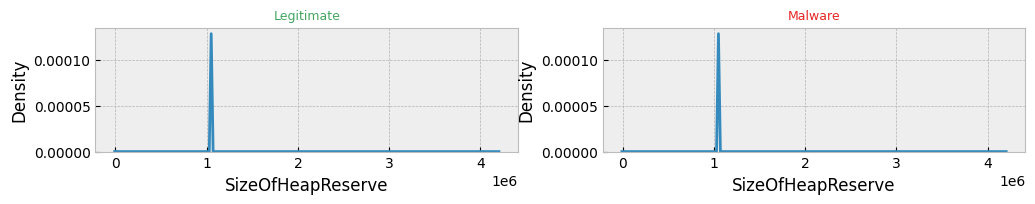

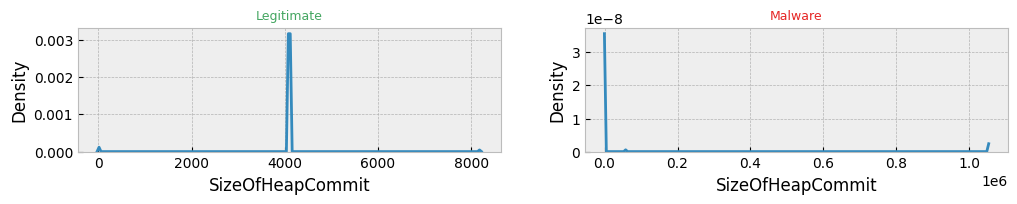

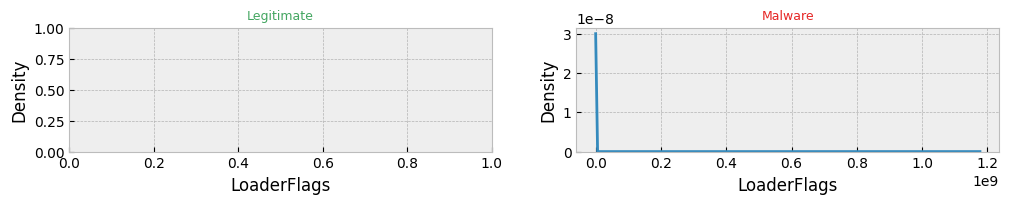

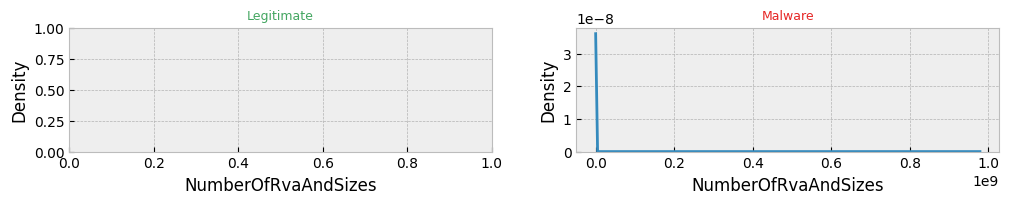

In [17]:
feats = getAllFeatures()

i=1

plt.style.use('bmh')
plt.rcParams['figure.max_open_warning'] = 60
plt.figure(figsize=(12, 140))

for feat in feats:
    plt.figure(figsize=(12, 100))
    x1 = plt.subplot(len(feats), 2, i)
    sns.kdeplot(data=fullDataset[fullDataset['Malware']==0][feat], bw_adjust=0.1, ax=x1, warn_singular=False)
    x1.set_title('Legitimate', fontsize=9, color='#44A661')
    x2 = plt.subplot(len(feats), 2, i+1)
    sns.kdeplot(data=fullDataset[fullDataset['Malware']==1][feat], bw_adjust=0.1, ax=x2, warn_singular=False)
    x2.set_title('Malware', fontsize=9, color='#E62625')
    i= i+2

En las gráficas anteriores se puede observar información muy valiosa. Si procedemos a su lectura, obtenemos por ejemplo, que los valores de la característica **e_cblp** (representa el número de bytes que están siendo utilizados en la última página del ejecutable) oscilan en torno a valores de 145 para los archivos legítimos mientras que para el malware los valores se encuentran cercanos a 0. Utilizaremos todos estos patrones junto con el mapa de calor de correlaciones entre características generado en el siguiente apartado, con el objetivo de seleccionar las características más adecuadas para el posterior entreno de los modelos.

**Mapa de calor de correlaciones entre características**

En un mapa de calor de correlación, cada variable está representada por una fila y una columna, y las celdas muestran la correlación entre ellas. El color de cada celda representa la fuerza y ​​dirección de la correlación, y los colores más oscuros indican correlaciones más fuertes (en nuestro caso, las correlaciones más fuertes se reflejan con colores azulados y rojizos intensos).

Todo esto es necesario porque cuando se utilizan datos para construir modelos, uno de los pasos más importantes es seleccionar qué variables servirán como características de entrada para el modelo. El mapa de calor de correlación es un buen comienzo para comprobar si alguna de las variables tiene una fuerte correlación entre sí.

In [18]:
# Construcción de los diferentes conjuntos de datos (entrenamiento y test)
X, y = balanceDataset(X, y, "u")
X_train, X_test, y_train, y_test = splitInTrainAndTest(X, y)

In [19]:
X

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_oemid,e_oeminfo,e_lfanew,Machine,NumberOfSections,...,MinorSubsystemVersion,SizeOfHeaders,CheckSum,SizeOfImage,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit
0,144,3,4,65535,184,0,0,224,34404,11,...,0,4096,317391,299008,1,16736,262144,4096,1048576,4096
1,144,3,4,65535,184,0,0,232,34404,10,...,0,4096,69729,57344,1,16736,262144,4096,1048576,4096
2,144,3,4,65535,184,0,0,200,34404,4,...,0,4096,26317,20480,3,352,262144,4096,1048576,4096
3,144,3,4,65535,184,0,0,248,34404,7,...,0,1024,4137979,4157440,2,16736,1048576,4096,1048576,4096
4,144,3,4,65535,184,0,0,264,332,6,...,0,1024,411027,372736,3,16704,262144,4096,1048576,4096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6909,144,3,4,65535,184,0,0,208,332,3,...,0,1024,0,159744,2,0,1048576,4096,1048576,4096
6910,144,3,4,65535,184,0,0,208,332,3,...,0,1024,0,159744,2,0,1048576,4096,1048576,4096
6911,144,3,4,65535,184,0,0,208,332,3,...,0,1024,0,159744,2,0,1048576,4096,1048576,4096
6912,144,3,4,65535,184,0,0,208,332,3,...,0,1024,0,159744,2,0,1048576,4096,1048576,4096


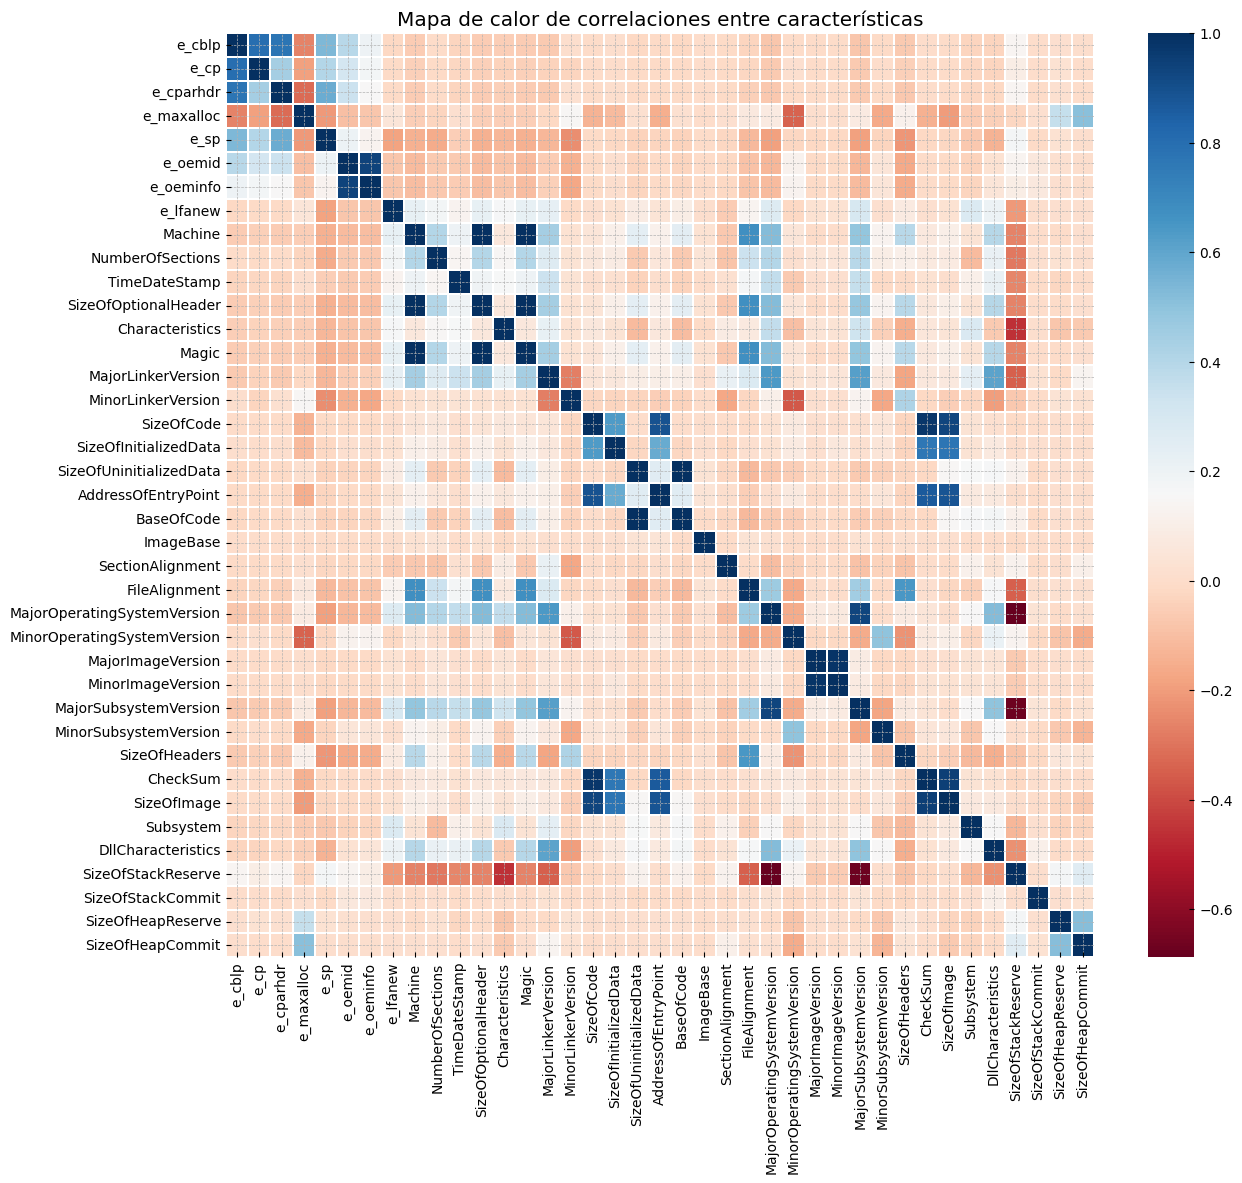

In [20]:
# Mapa de calor de correlación entre características del dataset
corrMatrix = X.corr(numeric_only=True)
plt.figure(figsize=(14, 12))
sns.heatmap(corrMatrix, cmap='RdBu', linewidths = 0.1)
plt.title('Mapa de calor de correlaciones entre características')
plt.show()

Los mapas de calor de correlación son importantes porque ayudan a identificar qué variables pueden dar lugar a multicolinealidad, lo que comprometería la integridad del modelo. La multicolinealidad ocurre cuando las variables independientes (posibles predictoras) están correlacionadas. Las variables independientes deberían ser eso, independientes. Esto se debe a que si el grado de correlación entre las variables independientes es alto, no podremos aislar la relación entre cada variable independiente y la variable dependiente (nuestro objetivo, "Malware").

Por tanto, por esta razón, en este caso de uso se ha considerado eliminar aquellas características que tengan un índice de correlación superior a +0.8 o inferior a -0.8.

In [21]:
# Creamos una nueva colección vacía de elementos únicos para almacenar aquellas características que tienen un índice de correlación superior a +0.8 o inferior a -0.8.
corrFeatures = set()

# Recorremos cada una de las posiciones de la matriz de correlaciones en búsqueda de características que se encuentren fuera del rango elegido.
for i in range(len(corrMatrix .columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > 0.8 or abs(corrMatrix.iloc[i, j]) < -0.8 :
            featureName = corrMatrix.columns[i]
            corrFeatures.add(featureName)

In [22]:
# Observamos la cantidad de características encontradas
len(corrFeatures)

9

In [23]:
# Observamos el nombre de las características encontradas
corrFeatures

{'AddressOfEntryPoint',
 'BaseOfCode',
 'CheckSum',
 'Magic',
 'MajorSubsystemVersion',
 'MinorImageVersion',
 'SizeOfImage',
 'SizeOfOptionalHeader',
 'e_oeminfo'}

### 4.3 Características elegidas

In [24]:
# Eliminamos del dataset las características anteriores
X = X.drop(corrFeatures, axis=1)

# Mostramos las 30 características elegidas
X.columns

Index(['e_cblp', 'e_cp', 'e_cparhdr', 'e_maxalloc', 'e_sp', 'e_oemid',
       'e_lfanew', 'Machine', 'NumberOfSections', 'TimeDateStamp',
       'Characteristics', 'MajorLinkerVersion', 'MinorLinkerVersion',
       'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData',
       'ImageBase', 'SectionAlignment', 'FileAlignment',
       'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion',
       'MajorImageVersion', 'MinorSubsystemVersion', 'SizeOfHeaders',
       'Subsystem', 'DllCharacteristics', 'SizeOfStackReserve',
       'SizeOfStackCommit', 'SizeOfHeapReserve', 'SizeOfHeapCommit'],
      dtype='object')

In [25]:
# Otra forma de representación de las 30 características elegidas
display(pd.DataFrame(X.columns, columns=["Características elegidas"]))

,Características elegidas
0,e_cblp
1,e_cp
2,e_cparhdr
3,e_maxalloc
4,e_sp
5,e_oemid
6,e_lfanew
7,Machine
8,NumberOfSections
9,TimeDateStamp


In [26]:
# Dimensión del nuevo conjunto de características
X.shape

(6914, 30)

## 5. Construcción del dataset final

Como se ha comentado anteriormente, nuestro conjunto de datos se encuentra desbalanceado debido a que existen más muestras de malware que de archivos legítimos. Quizás hubiera sido más fácil añadir más muestras de archivos legítimos a nuestro dataset pero se decidió dejar así la cantidad de muestras para poder aplicar las técnicas de balanceo.

Por tanto, para el desarrollo de este caso de uso se construirán tres datasets:

1. Conjunto de datos original desbalanceado
2. Conjunto de datos aplicando las técnicas de balanceo por sobremuestreo (oversampling)
3. Conjunto de datos aplicando las técnicas de balanceo por submuestreo (undersampling)

El objetivo de esta implementación es poder evaluar las diferencias existentes en la aplicación de diferentes modelos de aprendizaje automático sobre un conjunto de datos desbalanceado versus un conjunto de datos balanceado con técnicas de sobremuestreo o con técnicas de submuestreo.

### 5.1 Construcción del dataset sin aplicar ninguna técnica de balanceo

In [27]:
# Dividimos las variables independientes (características) de nuestra variable objetivo (Malware) en dos datasets.
X = fullDataset.iloc[:, :-1]
y = fullDataset.loc[:, ['Malware']]

# Obtenemos aquellas características con desviación estándar cero y las eliminamos del dataset de características.
zeroStdFeatures = getZeroStdFeatures()
X = fullDataset.drop(zeroStdFeatures, axis=1)

# Eliminamos, nuevamente del dataset de características, aquellas características que tienen un índice de correlación superior a +0.8 o inferior a -0.8.
X = X.drop(corrFeatures, axis=1)

# Almacenamos en la variable finalFeats las 30 características finales que hemos elegido en el apartado anterior.
# Estas características las necesitaremos para luego graficar el árbol de decisión a partir de esta matriz NumPy.
finalFeats = X.columns

# Dividimos el dataset en el conjunto de entrenamiento y en el conjunto de test.
X_train, X_test, y_train, y_test = splitInTrainAndTest(X, y)

In [28]:
print(X_train)

[[-0.12868227 -0.13120192 -0.12343783 ... -0.0148115  -0.01841811
  -0.01115817]
 [-0.14246772 -0.1314268  -0.12343783 ...  0.01405173 -0.01841811
  -0.01115817]
 [-0.12868227 -0.13120192 -0.12343783 ... -0.0148115  -0.01841811
  -0.01115817]
 ...
 [-0.14246772 -0.1314268  -0.12343783 ...  0.01405173 -0.01841811
  -0.01115817]
 [-0.12868227 -0.13120192 -0.12343783 ... -0.0148115  -0.01841811
  -0.01115817]
 [-0.12868227 -0.13120192 -0.12343783 ... -0.0148115  -0.01841811
  -0.01115817]]


### 5.2 Construcción del dataset aplicando la técnica de sobremuestreo (oversampling)

In [29]:
# Aprovechamos todo lo realizado en el apartado anterior en cuanto a división de los datasets y eliminación de caracaterísticas.
XOverSamp = X
yOverSamp = y

# Aplicamos la técnica de sobremuestreo.
XOverSamp, yOverSamp = balanceDataset(XOverSamp, yOverSamp, "o")

# Dividimos el nuevo dataset en el conjunto de entrenamiento y en el conjunto de test.
X_train_OS, X_test_OS, y_train_OS, y_test_OS = splitInTrainAndTest(XOverSamp, yOverSamp)

### 5.2 Construcción del dataset aplicando la técnica de submuestreo (undersampling)

In [30]:
# Igual que en caso anterior, aprovechamos todo lo realizado en el apartado 5.1 en cuanto a división de los datasets y eliminación de caracaterísticas.
XUnderSamp = X
yUnderSamp = y

# Aplicamos la técnica de submuestreo.
XUnderSamp, yUnderSamp = balanceDataset(XUnderSamp, yUnderSamp, "o")

# Dividimos el nuevo dataset en el conjunto de entrenamiento y en el conjunto de test.
X_train_US, X_test_US, y_train_US, y_test_US = splitInTrainAndTest(XUnderSamp, yUnderSamp)

## 6. Desarrollo de diferentes modelos

### 6.1 Creación de un modelo de aprendizaje automático aplicando el algoritmo "Árboles de decisión" (Decision Tree) sobre dataset sin balancear

1. Comenzaremos definiendo nuestro modelo con el uso del algoritmo de árboles de decisión y luego definiremos el valor de K que se empleará en la validación cruzada.
2. Para entrenar al modelo, llamaremos al método ***fit*** del objeto que representa nuestro modelo (model).
3. Durante el proceso de entrenamiento, calcularemos el tiempo de inicio y el tiempo de fin, con el objetivo de obtener el tiempo total invertido en el entrenamiento del modelo.
4. Aplicamos la técnica de validación cruzada y evaluamos el rendimiento del modelo generado, en nuestro dataset.
5. Imprimimos las diferentes puntuaciones, la puntuación media y la desviación estándar de la precisión obtenida.

In [31]:
model = DecisionTreeClassifier()                # Seleccionamos el algoritmo "Árboles de decisión" 

startTime = time.time()                         # Inicio del entrenamiento
trainingModel = model.fit(X_train, y_train)     # Entrenamiento del algoritmo "Árboles de decisión" con nuestros conjuntos de entrenamiento
endTime = time.time()                           # Fin del entrenamiento

timeSpent = endTime - startTime                 # Tiempo invertido en entrenar el modelo

kfold = KFold(7)                                                                             # Establecemos el valor de iteraciones de validación cruzada en 7
scores = cross_val_score(trainingModel, X_train, y_train, cv = kfold, scoring='accuracy')    #  Realiza validación cruzada y evalúa el rendimiento del modelo en el conjunto de datos

In [32]:
# Imprimirmos los resultados
print("El tiempo de entrenamiento del modelo ha sido:", timeSpent,"segundos.")
print("Puntuaciones de precisión obtenidas en cada iteración de la validación cruzada:\n", scores)
print("Precisión media: ", scores.mean())       # para ver el promedio de los resultados
print("Desviación estándar de la precisión:", scores.std())

El tiempo de entrenamiento del modelo ha sido: 0.02391982078552246 segundos.
Puntuaciones de precisión obtenidas en cada iteración de la validación cruzada:
 [0.99899598 0.99949799 0.99648594 0.99899598 0.99849398 0.99899548
 0.99899548]
Precisión media:  0.9986372626907141
Desviación estándar de la precisión: 0.0009183494295922933


**Graficamos el árbol de decisión**

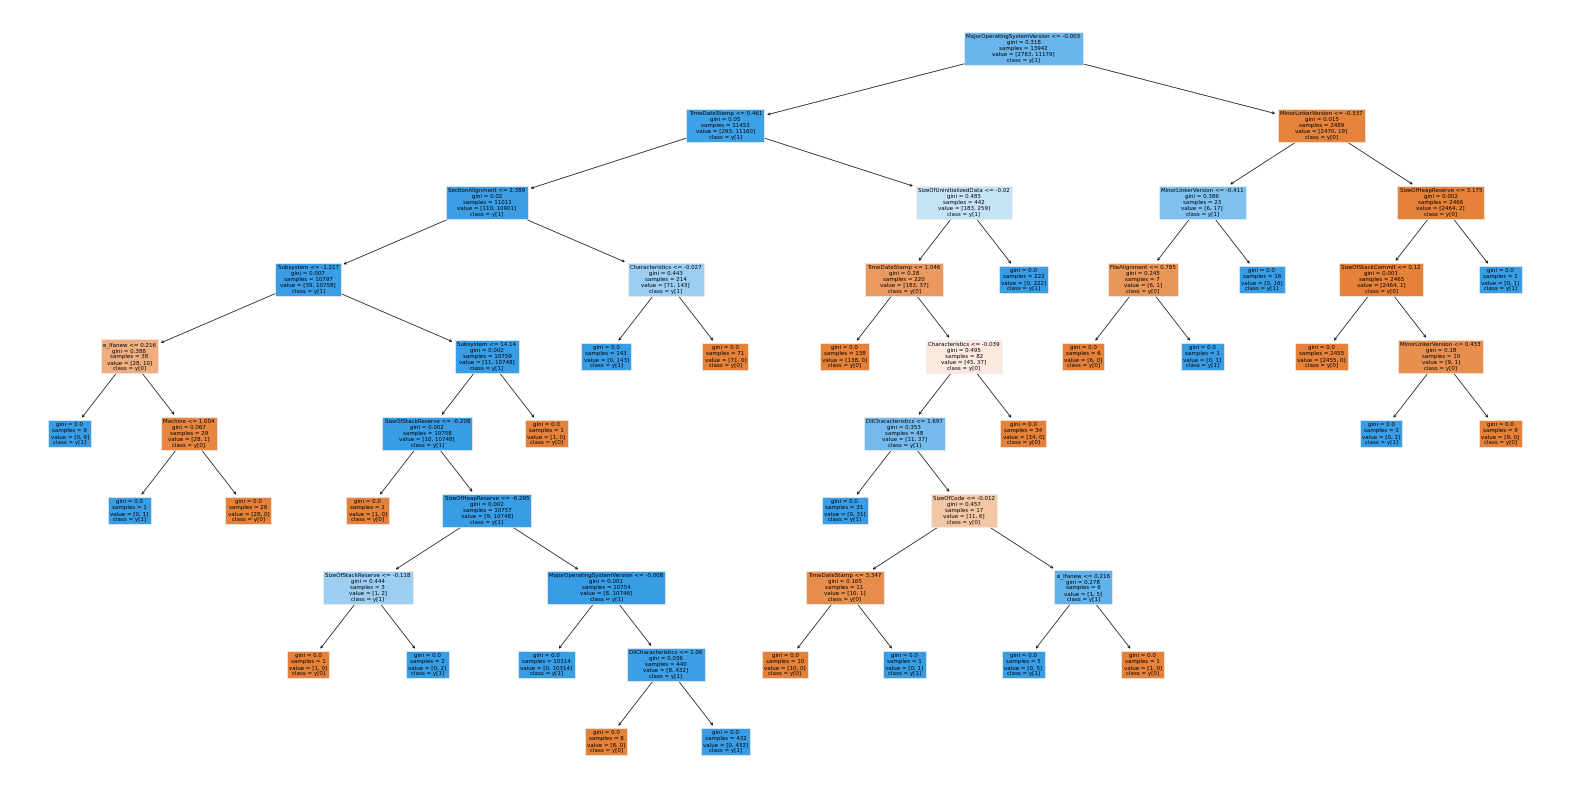

In [33]:
plt.figure(figsize=(20, 10))
plot_tree(trainingModel, filled=True, feature_names=finalFeats, class_names=True)
plt.show()

**Guardamos el modelo creado**

In [34]:
pklFilename = "trained_models/DecisionTreeModel.pkl"

with open(pklFilename, 'wb') as file:
    pickle.dump(trainingModel, file) 

### 6.2 Creación de un modelo de aprendizaje automático aplicando el algoritmo "K vecinos más cercanos" (K-Nearest-Neighbor) sobre dataset sin balancear

In [35]:
model = KNeighborsClassifier(n_neighbors=7)               # Seleccionamos el algoritmo K-Nearest-Neighbor 

startTime = time.time()                                   # Inicio del entrenamiento
trainingModel = model.fit(X_train, np.ravel(y_train))     # Entrenamiento del algoritmo K-Nearest-Neighbor con nuestros conjuntos de entrenamiento
endTime = time.time()                                     # Fin del entrenamiento

timeSpent = endTime - startTime                           # Tiempo invertido en entrenar el modelo

In [36]:
# Validación cruzada
kfold = KFold(7)                                                                                       # Establecemos el valor de iteraciones de validación cruzada en 7
scores = cross_val_score(trainingModel, X_train, np.ravel(y_train), cv = kfold, scoring='accuracy')    #  Realiza validación cruzada y evalúa el rendimiento del modelo en el conjunto de datos

In [37]:
# Predicción de las etiquetas para los datos de prueba (clasificación de los archivos)
y_pred = trainingModel.predict(X_test)
print(y_pred)

[0 0 1 ... 1 1 1]


In [38]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.9979919678714859


### 6.3 Automatización en la creación de varios modelos de aprendizaje aplicando diferentes algoritmos sobre el dataset sin balancear

Pasos:
1. Añadimos en un vector todos los algoritmos que deseamos aplicar para crear los diferentes modelos.
2. Recorremos cada uno de los algoritmos del vector y los entrenamos con nuestros datos para crear un modelo por cada algoritmo.
3. Realizamos validación cruzada del modelo entrenado y almacenamos tanto su media como su desviación estándar.
4. Imprimimos los resultados.

In [39]:
# Creamos una lista de listas para los datos que contendrá la tabla de resultados
resultTable = []

# Agregamos encabezados de columna a la tabla de resultados
headers = ["Algoritmo", "Puntuación media", "Desviación estándar", "Tiempo de entrenamiento"]

# Seleccionamos los algoritmos
algorithmsToUse = []

# Algoritmos de regresión
#algorithmsToUse.append(('LinealRegression', LinearRegression()))
algorithmsToUse.append(('LogisticRegression', LogisticRegression(max_iter=700)))

# Algoritmos de clasificación
algorithmsToUse.append(('K-Nearest-Neighbors_k=2', KNeighborsClassifier(n_neighbors=2)))
algorithmsToUse.append(('K-Nearest-Neighbors_k=3', KNeighborsClassifier(n_neighbors=3)))
algorithmsToUse.append(('K-Nearest-Neighbors_k=4', KNeighborsClassifier(n_neighbors=4)))
algorithmsToUse.append(('K-Nearest-Neighbors_k=5', KNeighborsClassifier(n_neighbors=5)))
algorithmsToUse.append(('K-Nearest-Neighbors_k=7', KNeighborsClassifier(n_neighbors=7)))
algorithmsToUse.append(('SupportVectorMachine', SVC()))
algorithmsToUse.append(('NaiveBayes', GaussianNB()))

# Algoritmos de agrupamiento o clustering
algorithmsToUse.append(('K-Means', KMeans()))

# Algoritmos basados en árboles de decisión
algorithmsToUse.append(('DecisionTree', DecisionTreeClassifier()))
algorithmsToUse.append(('RandomForest', RandomForestClassifier()))

# Creamos el vector que almacenará nuestros algoritmos entrenados
trainedModels = []
    
results = []
names = []

# Entrenamos a los diferentes algoritmos con nuestros conjuntos de entrenamiento
for algorithmName, algorithm in algorithmsToUse:
    # Validación cruzada
    kfold = KFold(7)
    # Medimos el tiempo de entrenamiento
    startTime = time.time()
    trainedModel = algorithm.fit(X_train, np.ravel(y_train))
    endTime = time.time()

    cvScores = cross_val_score(trainedModel, X_train, np.ravel(y_train), cv = kfold, scoring='accuracy')
    results.append(cvScores)
    names.append(algorithmName)
    
     # Limitamos la cantidad de decimales a 7
    meanScore = round(cvScores.mean(), 7)
    stdDev = round(cvScores.std(), 7)
    elapsedTime = round(endTime - startTime, 7)

    # Agregar los datos de cada algoritmo a la lista de datos de la tabla
    resultTable.append([algorithmName, meanScore, stdDev, elapsedTime])

    trainedModels.append((algorithmName, trainedModel))

# Imprimimos la tabla utilizando tabulate
print(tabulate(resultTable, headers=headers, floatfmt=".7f"))

Algoritmo                  Puntuación media    Desviación estándar    Tiempo de entrenamiento
-----------------------  ------------------  ---------------------  -------------------------
LogisticRegression                0.9721704              0.0023218                  0.0279062
K-Nearest-Neighbors_k=2           0.9969877              0.0010039                  0.0009968
K-Nearest-Neighbors_k=3           0.9971311              0.0009935                  0.0009966
K-Nearest-Neighbors_k=4           0.9967008              0.0011014                  0.0009966
K-Nearest-Neighbors_k=5           0.9969159              0.0005642                  0.0009966
K-Nearest-Neighbors_k=7           0.9961987              0.0010682                  0.0009968
SupportVectorMachine              0.9943336              0.0018735                  0.2053127
NaiveBayes                        0.4145683              0.0398695                  0.0039868
K-Means                           0.1623105              0.2

### 6.4 Automatización en la creación de varios modelos de aprendizaje aplicando diferentes algoritmos sobre el dataset balanceado aplicando la técnica de sobremuestreo (oversampling)

In [40]:
# Creamos una lista de listas para los datos que contendrá la tabla de resultados
resultTableOver = []

# Agregamos encabezados de columna a la tabla de resultados
headersOver = ["Algoritmo", "Puntuación media", "Desviación estándar", "Tiempo de entrenamiento"]

# Seleccionamos los algoritmos
algorithmsToUseOver = []

# Algoritmos de regresión
algorithmsToUseOver.append(('LogisticRegression', LogisticRegression(max_iter=700)))

# Algoritmos de clasificación
algorithmsToUseOver.append(('K-Nearest-Neighbors_k=2', KNeighborsClassifier(n_neighbors=2)))
algorithmsToUseOver.append(('K-Nearest-Neighbors_k=3', KNeighborsClassifier(n_neighbors=3)))
algorithmsToUseOver.append(('K-Nearest-Neighbors_k=4', KNeighborsClassifier(n_neighbors=4)))
algorithmsToUseOver.append(('K-Nearest-Neighbors_k=5', KNeighborsClassifier(n_neighbors=5)))
algorithmsToUseOver.append(('K-Nearest-Neighbors_k=7', KNeighborsClassifier(n_neighbors=7)))
algorithmsToUseOver.append(('SupportVectorMachine', SVC()))
algorithmsToUseOver.append(('NaiveBayes', GaussianNB()))

# Algoritmos de agrupamiento o clustering
algorithmsToUseOver.append(('K-Means', KMeans()))

# Algoritmos basados en árboles de decisión
algorithmsToUseOver.append(('DecisionTree', DecisionTreeClassifier()))
algorithmsToUseOver.append(('RandomForest', RandomForestClassifier()))

# Creamos el vector que almacenará nuestros algoritmos entrenados
trainedModelsOver = []
    
resultsOver = []
namesOver = []

# Entrenamos a los diferentes algoritmos con nuestros conjuntos de entrenamiento
for algorithmNameOver, algorithmOver in algorithmsToUseOver:
    
    # Validación cruzada
    kfold = KFold(7)
    
    # Medimos el tiempo de entrenamiento
    startTime = time.time()
    trainedModelOver = algorithmOver.fit(X_train_OS, np.ravel(y_train_OS))
    endTime = time.time()

    cvScoresOver = cross_val_score(trainedModelOver, X_train_OS, np.ravel(y_train_OS), cv = kfold, scoring='accuracy')
    resultsOver.append(cvScoresOver)
    namesOver.append(algorithmNameOver)

    # Limitamos la cantidad de decimales a 7
    meanScoreOver = round(cvScoresOver.mean(), 7)
    stdDevOver = round(cvScoresOver.std(), 7)
    elapsedTimeOver = round(endTime - startTime, 7)


    # Agregar los datos de cada algoritmo a la lista de datos de la tabla
    resultTableOver.append([algorithmNameOver, meanScoreOver, stdDevOver, elapsedTimeOver])
    
    trainedModelsOver.append((algorithmNameOver, trainedModelOver))

# Imprimimos la tabla utilizando tabulate
print(tabulate(resultTableOver, headers=headersOver, floatfmt=".7f"))

Algoritmo                  Puntuación media    Desviación estándar    Tiempo de entrenamiento
-----------------------  ------------------  ---------------------  -------------------------
LogisticRegression                0.9773184              0.0017474                  0.0488365
K-Nearest-Neighbors_k=2           0.9984790              0.0003522                  0.0019932
K-Nearest-Neighbors_k=3           0.9985684              0.0003287                  0.0019934
K-Nearest-Neighbors_k=4           0.9978079              0.0003348                  0.0019932
K-Nearest-Neighbors_k=5           0.9972263              0.0007187                  0.0019934
K-Nearest-Neighbors_k=7           0.9966000              0.0009081                  0.0019934
SupportVectorMachine              0.9953921              0.0006422                  0.3857102
NaiveBayes                        0.6452375              0.0179274                  0.0069766
K-Means                           0.2019418              0.1

### 6.5 Automatización en la creación de varios modelos de aprendizaje aplicando diferentes algoritmos sobre el dataset balanceado aplicando la técnica de submuestreo (undersampling)

In [41]:
# Creamos una lista de listas para los datos que contendrá la tabla de resultados
resultTableUnder = []

# Agregamos encabezados de columna a la tabla de resultados
headersUnder = ["Algoritmo", "Puntuación media", "Desviación estándar", "Tiempo de entrenamiento"]

# Seleccionamos los algoritmos
algorithmsToUseUnder = []

# Algoritmos de regresión
algorithmsToUseUnder.append(('LogisticRegression', LogisticRegression(max_iter=700)))

# Algoritmos de clasificación
algorithmsToUseUnder.append(('K-Nearest-Neighbors_k=2', KNeighborsClassifier(n_neighbors=2)))
algorithmsToUseUnder.append(('K-Nearest-Neighbors_k=3', KNeighborsClassifier(n_neighbors=3)))
algorithmsToUseUnder.append(('K-Nearest-Neighbors_k=4', KNeighborsClassifier(n_neighbors=4)))
algorithmsToUseUnder.append(('K-Nearest-Neighbors_k=5', KNeighborsClassifier(n_neighbors=5)))
algorithmsToUseUnder.append(('K-Nearest-Neighbors_k=7', KNeighborsClassifier(n_neighbors=7)))
algorithmsToUseUnder.append(('SupportVectorMachine', SVC()))
algorithmsToUseUnder.append(('NaiveBayes', GaussianNB()))

# Algoritmos de agrupamiento o clustering
algorithmsToUseUnder.append(('K-Means', KMeans()))

# Algoritmos basados en árboles de decisión
algorithmsToUseUnder.append(('DecisionTree', DecisionTreeClassifier()))
algorithmsToUseUnder.append(('RandomForest', RandomForestClassifier()))

# Creamos el vector que almacenará nuestros algoritmos entrenados
trainedModelsUnder = []

    
resultsUnder = []
namesUnder = []

# Entrenamos a los diferentes algoritmos con nuestros conjuntos de entrenamiento
for algorithmNameUnder, algorithmUnder in algorithmsToUseUnder:
    
    # Validación cruzada
    kfold = KFold(7)
    
    # Medimos el tiempo de entrenamiento
    startTime = time.time()
    trainedModelUnder = algorithmUnder.fit(X_train_US, np.ravel(y_train_US))
    endTime = time.time()

    cvScoresUnder = cross_val_score(trainedModelUnder, X_train_US, np.ravel(y_train_US), cv = kfold, scoring='accuracy')
    resultsUnder.append(cvScoresUnder)
    namesUnder.append(algorithmNameUnder)

    # Limitamos la cantidad de decimales a 7
    meanScoreUnder = round(cvScoresUnder.mean(), 7)
    stdDevUnder = round(cvScoresUnder.std(), 7)
    elapsedTimeUnder = round(endTime - startTime, 7)


    # Agregar los datos de cada algoritmo a la lista de datos de la tabla
    resultTableUnder.append([algorithmNameUnder, meanScoreUnder, stdDevUnder, elapsedTimeUnder])
    
    trainedModelsUnder.append((algorithmNameUnder, trainedModelUnder))

# Imprimimos la tabla utilizando tabulate
print(tabulate(resultTableUnder, headers=headersUnder, floatfmt=".7f"))

Algoritmo                  Puntuación media    Desviación estándar    Tiempo de entrenamiento
-----------------------  ------------------  ---------------------  -------------------------
LogisticRegression                0.9773184              0.0017474                  0.0488362
K-Nearest-Neighbors_k=2           0.9984790              0.0003522                  0.0019934
K-Nearest-Neighbors_k=3           0.9985684              0.0003287                  0.0019934
K-Nearest-Neighbors_k=4           0.9978079              0.0003348                  0.0019932
K-Nearest-Neighbors_k=5           0.9972263              0.0007187                  0.0029910
K-Nearest-Neighbors_k=7           0.9966000              0.0009081                  0.0029902
SupportVectorMachine              0.9953921              0.0006422                  0.4006598
NaiveBayes                        0.6452375              0.0179274                  0.0069773
K-Means                           0.2620716              0.1